In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 32)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 32)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7152 - acc: 0.1041
Epoch 00001: val_loss improved from inf to 2.63212, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/001-2.6321.hdf5
36805/36805 [==============================] - 18s 500us/sample - loss: 2.7152 - acc: 0.1041 - val_loss: 2.6321 - val_acc: 0.1766
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5896 - acc: 0.1563
Epoch 00002: val_loss improved from 2.63212 to 2.44033, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/002-2.4403.hdf5
36805/36805 [==============================] - 16s 435us/sample - loss: 2.5896 - acc: 0.1563 - val_loss: 2.4403 - val_acc: 0.2553
Epoch 3/500
36736/36805 [============================>.] - ET

Epoch 21/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6950 - acc: 0.4348
Epoch 00021: val_loss improved from 1.42107 to 1.39757, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/021-1.3976.hdf5
36805/36805 [==============================] - 16s 426us/sample - loss: 1.6949 - acc: 0.4350 - val_loss: 1.3976 - val_acc: 0.5775
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6833 - acc: 0.4412
Epoch 00022: val_loss improved from 1.39757 to 1.38363, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/022-1.3836.hdf5
36805/36805 [==============================] - 16s 426us/sample - loss: 1.6833 - acc: 0.4412 - val_loss: 1.3836 - val_acc: 0.5886
Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6651 - acc: 0.4441
Epoch 00023: val_loss improved from 1.38363 to 1.36035, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_ch

Epoch 43/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4804 - acc: 0.5103
Epoch 00043: val_loss did not improve from 1.15126
36805/36805 [==============================] - 16s 427us/sample - loss: 1.4800 - acc: 0.5103 - val_loss: 1.1553 - val_acc: 0.6564
Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4731 - acc: 0.5151
Epoch 00044: val_loss improved from 1.15126 to 1.14545, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/044-1.1455.hdf5
36805/36805 [==============================] - 16s 425us/sample - loss: 1.4731 - acc: 0.5150 - val_loss: 1.1455 - val_acc: 0.6583
Epoch 45/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4636 - acc: 0.5181
Epoch 00045: val_loss improved from 1.14545 to 1.13203, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/045-1.1320.hdf5
36805/36805 [==============================] - 16s 425us/sample - loss: 1.4635 - a

Epoch 66/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3783 - acc: 0.5501
Epoch 00066: val_loss did not improve from 1.03476
36805/36805 [==============================] - 16s 424us/sample - loss: 1.3783 - acc: 0.5501 - val_loss: 1.0393 - val_acc: 0.6923
Epoch 67/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3712 - acc: 0.5522
Epoch 00067: val_loss improved from 1.03476 to 1.03305, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/067-1.0330.hdf5
36805/36805 [==============================] - 16s 422us/sample - loss: 1.3715 - acc: 0.5523 - val_loss: 1.0330 - val_acc: 0.6937
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3754 - acc: 0.5474
Epoch 00068: val_loss improved from 1.03305 to 1.03110, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/068-1.0311.hdf5
36805/36805 [==============================] - 16s 424us/sample - loss: 1.3754 - a

Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3295 - acc: 0.5688
Epoch 00089: val_loss did not improve from 0.97763
36805/36805 [==============================] - 16s 423us/sample - loss: 1.3295 - acc: 0.5688 - val_loss: 0.9836 - val_acc: 0.7114
Epoch 90/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3219 - acc: 0.5692
Epoch 00090: val_loss improved from 0.97763 to 0.97545, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/090-0.9755.hdf5
36805/36805 [==============================] - 16s 426us/sample - loss: 1.3218 - acc: 0.5692 - val_loss: 0.9755 - val_acc: 0.7128
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3250 - acc: 0.5708
Epoch 00091: val_loss improved from 0.97545 to 0.97374, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/091-0.9737.hdf5
36805/36805 [==============================] - 16s 426us/sample - loss: 1.3249 - a

Epoch 114/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2827 - acc: 0.5831
Epoch 00114: val_loss did not improve from 0.93201
36805/36805 [==============================] - 16s 421us/sample - loss: 1.2830 - acc: 0.5829 - val_loss: 0.9429 - val_acc: 0.7265
Epoch 115/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2860 - acc: 0.5830
Epoch 00115: val_loss did not improve from 0.93201
36805/36805 [==============================] - 16s 423us/sample - loss: 1.2866 - acc: 0.5829 - val_loss: 0.9398 - val_acc: 0.7214
Epoch 116/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2866 - acc: 0.5810
Epoch 00116: val_loss did not improve from 0.93201
36805/36805 [==============================] - 16s 424us/sample - loss: 1.2874 - acc: 0.5808 - val_loss: 0.9343 - val_acc: 0.7277
Epoch 117/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2821 - acc: 0.5863
Epoch 00117: val_loss improved from 0.93201 to 0.92678, saving mo

36800/36805 [============================>.] - ETA: 0s - loss: 1.2466 - acc: 0.5933
Epoch 00140: val_loss did not improve from 0.89449
36805/36805 [==============================] - 16s 425us/sample - loss: 1.2467 - acc: 0.5932 - val_loss: 0.8969 - val_acc: 0.7333
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2534 - acc: 0.5933
Epoch 00141: val_loss did not improve from 0.89449
36805/36805 [==============================] - 16s 430us/sample - loss: 1.2534 - acc: 0.5933 - val_loss: 0.9035 - val_acc: 0.7361
Epoch 142/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2517 - acc: 0.5931
Epoch 00142: val_loss improved from 0.89449 to 0.88808, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/142-0.8881.hdf5
36805/36805 [==============================] - 16s 426us/sample - loss: 1.2514 - acc: 0.5931 - val_loss: 0.8881 - val_acc: 0.7361
Epoch 143/500
36736/36805 [============================>.] - ETA: 0s -

Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2246 - acc: 0.6032
Epoch 00167: val_loss did not improve from 0.85971
36805/36805 [==============================] - 16s 424us/sample - loss: 1.2248 - acc: 0.6031 - val_loss: 0.8708 - val_acc: 0.7470
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2261 - acc: 0.6028
Epoch 00168: val_loss did not improve from 0.85971
36805/36805 [==============================] - 16s 423us/sample - loss: 1.2262 - acc: 0.6028 - val_loss: 0.8658 - val_acc: 0.7442
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2238 - acc: 0.6051
Epoch 00169: val_loss did not improve from 0.85971
36805/36805 [==============================] - 16s 427us/sample - loss: 1.2239 - acc: 0.6051 - val_loss: 0.8817 - val_acc: 0.7435
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2290 - acc: 0.6039
Epoch 00170: val_loss did not improve from 0.85971
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 1.2069 - acc: 0.6111
Epoch 00195: val_loss did not improve from 0.84915
36805/36805 [==============================] - 16s 423us/sample - loss: 1.2069 - acc: 0.6112 - val_loss: 0.8533 - val_acc: 0.7480
Epoch 196/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1993 - acc: 0.6080
Epoch 00196: val_loss improved from 0.84915 to 0.84554, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/196-0.8455.hdf5
36805/36805 [==============================] - 16s 424us/sample - loss: 1.1992 - acc: 0.6080 - val_loss: 0.8455 - val_acc: 0.7501
Epoch 197/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2062 - acc: 0.6101
Epoch 00197: val_loss did not improve from 0.84554
36805/36805 [==============================] - 16s 421us/sample - loss: 1.2061 - acc: 0.6102 - val_loss: 0.8475 - val_acc: 0.7491
Epoch 198/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 223/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1858 - acc: 0.6146
Epoch 00223: val_loss did not improve from 0.82735
36805/36805 [==============================] - 16s 424us/sample - loss: 1.1861 - acc: 0.6145 - val_loss: 0.8315 - val_acc: 0.7559
Epoch 224/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1888 - acc: 0.6177
Epoch 00224: val_loss did not improve from 0.82735
36805/36805 [==============================] - 16s 423us/sample - loss: 1.1888 - acc: 0.6176 - val_loss: 0.8495 - val_acc: 0.7494
Epoch 225/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1856 - acc: 0.6151
Epoch 00225: val_loss did not improve from 0.82735
36805/36805 [==============================] - 16s 423us/sample - loss: 1.1859 - acc: 0.6150 - val_loss: 0.8311 - val_acc: 0.7559
Epoch 226/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1820 - acc: 0.6147
Epoch 00226: val_loss did not improve from 0.82735
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 1.1734 - acc: 0.6249
Epoch 00251: val_loss did not improve from 0.81270
36805/36805 [==============================] - 16s 424us/sample - loss: 1.1733 - acc: 0.6250 - val_loss: 0.8161 - val_acc: 0.7580
Epoch 252/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1751 - acc: 0.6224
Epoch 00252: val_loss improved from 0.81270 to 0.81175, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/252-0.8118.hdf5
36805/36805 [==============================] - 16s 424us/sample - loss: 1.1751 - acc: 0.6224 - val_loss: 0.8118 - val_acc: 0.7561
Epoch 253/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1707 - acc: 0.6214
Epoch 00253: val_loss did not improve from 0.81175
36805/36805 [==============================] - 16s 423us/sample - loss: 1.1707 - acc: 0.6213 - val_loss: 0.8222 - val_acc: 0.7559
Epoch 254/500
36736/36805 [============================>.] - ETA: 0s -

Epoch 279/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1606 - acc: 0.6224
Epoch 00279: val_loss improved from 0.80141 to 0.80043, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/279-0.8004.hdf5
36805/36805 [==============================] - 16s 425us/sample - loss: 1.1605 - acc: 0.6224 - val_loss: 0.8004 - val_acc: 0.7643
Epoch 280/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1542 - acc: 0.6243
Epoch 00280: val_loss did not improve from 0.80043
36805/36805 [==============================] - 15s 421us/sample - loss: 1.1545 - acc: 0.6243 - val_loss: 0.8092 - val_acc: 0.7624
Epoch 281/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1553 - acc: 0.6248
Epoch 00281: val_loss did not improve from 0.80043
36805/36805 [==============================] - 16s 422us/sample - loss: 1.1553 - acc: 0.6248 - val_loss: 0.8080 - val_acc: 0.7668
Epoch 282/500
36800/36805 [============================>

Epoch 307/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1569 - acc: 0.6267
Epoch 00307: val_loss did not improve from 0.79263
36805/36805 [==============================] - 16s 422us/sample - loss: 1.1569 - acc: 0.6268 - val_loss: 0.8039 - val_acc: 0.7624
Epoch 308/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1449 - acc: 0.6299
Epoch 00308: val_loss did not improve from 0.79263
36805/36805 [==============================] - 16s 425us/sample - loss: 1.1451 - acc: 0.6299 - val_loss: 0.7949 - val_acc: 0.7638
Epoch 309/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1400 - acc: 0.6280
Epoch 00309: val_loss did not improve from 0.79263
36805/36805 [==============================] - 16s 423us/sample - loss: 1.1401 - acc: 0.6280 - val_loss: 0.7935 - val_acc: 0.7643
Epoch 310/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1465 - acc: 0.6306
Epoch 00310: val_loss did not improve from 0.79263
36805/36805 [=

Epoch 335/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1346 - acc: 0.6309
Epoch 00335: val_loss did not improve from 0.78507
36805/36805 [==============================] - 16s 423us/sample - loss: 1.1347 - acc: 0.6309 - val_loss: 0.7903 - val_acc: 0.7657
Epoch 336/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1394 - acc: 0.6311
Epoch 00336: val_loss did not improve from 0.78507
36805/36805 [==============================] - 16s 422us/sample - loss: 1.1393 - acc: 0.6311 - val_loss: 0.7904 - val_acc: 0.7664
Epoch 337/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1307 - acc: 0.6348
Epoch 00337: val_loss did not improve from 0.78507
36805/36805 [==============================] - 16s 424us/sample - loss: 1.1307 - acc: 0.6348 - val_loss: 0.7900 - val_acc: 0.7624
Epoch 338/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1355 - acc: 0.6333
Epoch 00338: val_loss did not improve from 0.78507
36805/36805 [=

Epoch 363/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1325 - acc: 0.6368
Epoch 00363: val_loss did not improve from 0.77305
36805/36805 [==============================] - 16s 422us/sample - loss: 1.1322 - acc: 0.6369 - val_loss: 0.7778 - val_acc: 0.7701
Epoch 364/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1357 - acc: 0.6338
Epoch 00364: val_loss did not improve from 0.77305
36805/36805 [==============================] - 16s 423us/sample - loss: 1.1357 - acc: 0.6339 - val_loss: 0.7930 - val_acc: 0.7615
Epoch 365/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1325 - acc: 0.6323
Epoch 00365: val_loss did not improve from 0.77305
36805/36805 [==============================] - 16s 422us/sample - loss: 1.1326 - acc: 0.6323 - val_loss: 0.7810 - val_acc: 0.7678
Epoch 366/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1278 - acc: 0.6341
Epoch 00366: val_loss did not improve from 0.77305
36805/36805 [=

Epoch 392/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1169 - acc: 0.6355
Epoch 00392: val_loss did not improve from 0.77033
36805/36805 [==============================] - 16s 424us/sample - loss: 1.1169 - acc: 0.6355 - val_loss: 0.7928 - val_acc: 0.7643
Epoch 393/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1167 - acc: 0.6364
Epoch 00393: val_loss improved from 0.77033 to 0.76757, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv_checkpoint/393-0.7676.hdf5
36805/36805 [==============================] - 16s 425us/sample - loss: 1.1167 - acc: 0.6364 - val_loss: 0.7676 - val_acc: 0.7696
Epoch 394/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1244 - acc: 0.6356
Epoch 00394: val_loss did not improve from 0.76757
36805/36805 [==============================] - 16s 426us/sample - loss: 1.1244 - acc: 0.6356 - val_loss: 0.7721 - val_acc: 0.7689
Epoch 395/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 1.1081 - acc: 0.6408
Epoch 00420: val_loss did not improve from 0.76371
36805/36805 [==============================] - 16s 426us/sample - loss: 1.1081 - acc: 0.6408 - val_loss: 0.7719 - val_acc: 0.7706
Epoch 421/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.1181 - acc: 0.6379
Epoch 00421: val_loss did not improve from 0.76371
36805/36805 [==============================] - 16s 426us/sample - loss: 1.1173 - acc: 0.6380 - val_loss: 0.7732 - val_acc: 0.7717
Epoch 422/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1062 - acc: 0.6389
Epoch 00422: val_loss did not improve from 0.76371
36805/36805 [==============================] - 16s 426us/sample - loss: 1.1062 - acc: 0.6389 - val_loss: 0.7693 - val_acc: 0.7727
Epoch 423/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1013 - acc: 0.6452
Epoch 00423: val_loss did not improve from 0.76371
36805/36805 [===============

Epoch 449/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1062 - acc: 0.6410
Epoch 00449: val_loss did not improve from 0.75747
36805/36805 [==============================] - 15s 421us/sample - loss: 1.1060 - acc: 0.6409 - val_loss: 0.7595 - val_acc: 0.7745
Epoch 450/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1091 - acc: 0.6387
Epoch 00450: val_loss did not improve from 0.75747
36805/36805 [==============================] - 16s 423us/sample - loss: 1.1090 - acc: 0.6388 - val_loss: 0.7654 - val_acc: 0.7708
Epoch 451/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1004 - acc: 0.6432
Epoch 00451: val_loss did not improve from 0.75747
36805/36805 [==============================] - 16s 423us/sample - loss: 1.1006 - acc: 0.6433 - val_loss: 0.7679 - val_acc: 0.7717
Epoch 452/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1062 - acc: 0.6396
Epoch 00452: val_loss did not improve from 0.75747
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 1.1026 - acc: 0.6430
Epoch 00476: val_loss did not improve from 0.74646
36805/36805 [==============================] - 16s 421us/sample - loss: 1.1027 - acc: 0.6430 - val_loss: 0.7554 - val_acc: 0.7773
Epoch 477/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1030 - acc: 0.6394
Epoch 00477: val_loss did not improve from 0.74646
36805/36805 [==============================] - 16s 423us/sample - loss: 1.1031 - acc: 0.6394 - val_loss: 0.7600 - val_acc: 0.7750
Epoch 478/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0931 - acc: 0.6453
Epoch 00478: val_loss did not improve from 0.74646
36805/36805 [==============================] - 16s 424us/sample - loss: 1.0932 - acc: 0.6453 - val_loss: 0.7566 - val_acc: 0.7789
Epoch 479/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0972 - acc: 0.6427
Epoch 00479: val_loss did not improve from 0.74646
36805/36805 [===============

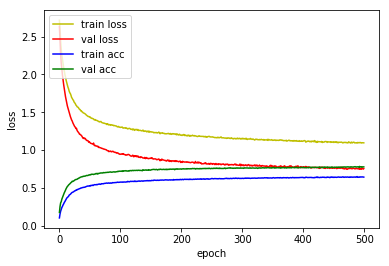

4815/4815 [==============================] - 1s 237us/sample - loss: 0.8415 - acc: 0.7468
Loss: 0.8415316059829537 Accuracy: 0.7468328

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7293 - acc: 0.0962
Epoch 00001: val_loss improved from inf to 2.64463, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/001-2.6446.hdf5
36805/36805 [==============================] - 18s 476us/sample - loss: 2.7294 - acc: 0.0962 - val_loss: 2.6446 - val_acc: 0.1242
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5410 - acc: 0.1700
Epoch 00002: val_loss improved from 2.64463 to 2.32217, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/002-2.3222.hdf5
36805/36805 [==============================] - 16s 435us/sample - loss: 2.5409 - acc: 0.1700 - val_loss: 2.3222 - val_acc: 0.2895
Epoch 3/500
36800/36805 [==========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4079 - acc: 0.5432
Epoch 00022: val_loss improved from 1.13333 to 1.11042, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/022-1.1104.hdf5
36805/36805 [==============================] - 16s 438us/sample - loss: 1.4080 - acc: 0.5432 - val_loss: 1.1104 - val_acc: 0.6695
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3934 - acc: 0.5515
Epoch 00023: val_loss improved from 1.11042 to 1.08074, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/023-1.0807.hdf5
36805/36805 [==============================] - 16s 438us/sample - loss: 1.3934 - acc: 0.5514 - val_loss: 1.0807 - val_acc: 0.6820
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3698 - acc: 0.5598
Epoch 00024: val_loss improved from 1.08074 to 1.05326, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_ch

36800/36805 [============================>.] - ETA: 0s - loss: 1.1502 - acc: 0.6322
Epoch 00044: val_loss did not improve from 0.84094
36805/36805 [==============================] - 16s 437us/sample - loss: 1.1503 - acc: 0.6322 - val_loss: 0.8423 - val_acc: 0.7549
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1448 - acc: 0.6365
Epoch 00045: val_loss improved from 0.84094 to 0.82839, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/045-0.8284.hdf5
36805/36805 [==============================] - 16s 436us/sample - loss: 1.1448 - acc: 0.6365 - val_loss: 0.8284 - val_acc: 0.7605
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1407 - acc: 0.6374
Epoch 00046: val_loss improved from 0.82839 to 0.80938, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/046-0.8094.hdf5
36805/36805 [==============================] - 16s 438us/sample - loss: 1.1407 - acc: 0.6373 - 

Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0394 - acc: 0.6676
Epoch 00068: val_loss improved from 0.72556 to 0.71960, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/068-0.7196.hdf5
36805/36805 [==============================] - 16s 437us/sample - loss: 1.0394 - acc: 0.6676 - val_loss: 0.7196 - val_acc: 0.7929
Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0299 - acc: 0.6722
Epoch 00069: val_loss did not improve from 0.71960
36805/36805 [==============================] - 16s 436us/sample - loss: 1.0300 - acc: 0.6722 - val_loss: 0.7261 - val_acc: 0.7873
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0383 - acc: 0.6703
Epoch 00070: val_loss improved from 0.71960 to 0.71543, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/070-0.7154.hdf5
36805/36805 [==============================] - 16s 436us/sample - loss: 1.0384 - a

Epoch 93/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9809 - acc: 0.6881
Epoch 00093: val_loss improved from 0.66404 to 0.66279, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/093-0.6628.hdf5
36805/36805 [==============================] - 16s 438us/sample - loss: 0.9809 - acc: 0.6882 - val_loss: 0.6628 - val_acc: 0.8076
Epoch 94/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9720 - acc: 0.6895
Epoch 00094: val_loss improved from 0.66279 to 0.65345, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/094-0.6535.hdf5
36805/36805 [==============================] - 16s 438us/sample - loss: 0.9720 - acc: 0.6895 - val_loss: 0.6535 - val_acc: 0.8085
Epoch 95/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9814 - acc: 0.6895
Epoch 00095: val_loss did not improve from 0.65345
36805/36805 [==============================] - 16s 434us/sample - loss: 0.9814 - a

Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9356 - acc: 0.7035
Epoch 00119: val_loss did not improve from 0.62439
36805/36805 [==============================] - 16s 435us/sample - loss: 0.9358 - acc: 0.7034 - val_loss: 0.6328 - val_acc: 0.8146
Epoch 120/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9451 - acc: 0.7021
Epoch 00120: val_loss did not improve from 0.62439
36805/36805 [==============================] - 16s 437us/sample - loss: 0.9452 - acc: 0.7020 - val_loss: 0.6319 - val_acc: 0.8153
Epoch 121/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9387 - acc: 0.7011
Epoch 00121: val_loss did not improve from 0.62439
36805/36805 [==============================] - 16s 435us/sample - loss: 0.9386 - acc: 0.7011 - val_loss: 0.6361 - val_acc: 0.8097
Epoch 122/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9315 - acc: 0.7044
Epoch 00122: val_loss improved from 0.62439 to 0.62345, saving mo

36800/36805 [============================>.] - ETA: 0s - loss: 0.9007 - acc: 0.7128
Epoch 00145: val_loss did not improve from 0.59306
36805/36805 [==============================] - 16s 435us/sample - loss: 0.9008 - acc: 0.7127 - val_loss: 0.6099 - val_acc: 0.8197
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8982 - acc: 0.7135
Epoch 00146: val_loss did not improve from 0.59306
36805/36805 [==============================] - 16s 434us/sample - loss: 0.8982 - acc: 0.7135 - val_loss: 0.5978 - val_acc: 0.8195
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9026 - acc: 0.7145
Epoch 00147: val_loss did not improve from 0.59306
36805/36805 [==============================] - 16s 437us/sample - loss: 0.9026 - acc: 0.7145 - val_loss: 0.5960 - val_acc: 0.8239
Epoch 148/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9008 - acc: 0.7131
Epoch 00148: val_loss did not improve from 0.59306
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.8771 - acc: 0.7218
Epoch 00172: val_loss did not improve from 0.57231
36805/36805 [==============================] - 16s 439us/sample - loss: 0.8770 - acc: 0.7219 - val_loss: 0.5855 - val_acc: 0.8265
Epoch 173/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8702 - acc: 0.7224
Epoch 00173: val_loss did not improve from 0.57231
36805/36805 [==============================] - 16s 436us/sample - loss: 0.8702 - acc: 0.7223 - val_loss: 0.5800 - val_acc: 0.8293
Epoch 174/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8699 - acc: 0.7248
Epoch 00174: val_loss improved from 0.57231 to 0.57009, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/174-0.5701.hdf5
36805/36805 [==============================] - 16s 437us/sample - loss: 0.8699 - acc: 0.7248 - val_loss: 0.5701 - val_acc: 0.8300
Epoch 175/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.8580 - acc: 0.7286
Epoch 00199: val_loss did not improve from 0.55757
36805/36805 [==============================] - 16s 441us/sample - loss: 0.8579 - acc: 0.7287 - val_loss: 0.5613 - val_acc: 0.8351
Epoch 200/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8571 - acc: 0.7257
Epoch 00200: val_loss did not improve from 0.55757
36805/36805 [==============================] - 16s 444us/sample - loss: 0.8574 - acc: 0.7257 - val_loss: 0.5630 - val_acc: 0.8367
Epoch 201/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8540 - acc: 0.7298
Epoch 00201: val_loss improved from 0.55757 to 0.55719, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/201-0.5572.hdf5
36805/36805 [==============================] - 16s 442us/sample - loss: 0.8539 - acc: 0.7299 - val_loss: 0.5572 - val_acc: 0.8332
Epoch 202/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.8364 - acc: 0.7329
Epoch 00226: val_loss did not improve from 0.54334
36805/36805 [==============================] - 16s 440us/sample - loss: 0.8363 - acc: 0.7329 - val_loss: 0.5488 - val_acc: 0.8423
Epoch 227/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8449 - acc: 0.7328
Epoch 00227: val_loss did not improve from 0.54334
36805/36805 [==============================] - 16s 436us/sample - loss: 0.8451 - acc: 0.7327 - val_loss: 0.5443 - val_acc: 0.8449
Epoch 228/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8320 - acc: 0.7335
Epoch 00228: val_loss did not improve from 0.54334
36805/36805 [==============================] - 16s 436us/sample - loss: 0.8320 - acc: 0.7335 - val_loss: 0.5563 - val_acc: 0.8409
Epoch 229/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8415 - acc: 0.7328
Epoch 00229: val_loss did not improve from 0.54334
36805/36805 [===============

Epoch 255/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8173 - acc: 0.7416
Epoch 00255: val_loss did not improve from 0.53076
36805/36805 [==============================] - 16s 436us/sample - loss: 0.8172 - acc: 0.7416 - val_loss: 0.5324 - val_acc: 0.8444
Epoch 256/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8215 - acc: 0.7390
Epoch 00256: val_loss did not improve from 0.53076
36805/36805 [==============================] - 16s 437us/sample - loss: 0.8214 - acc: 0.7391 - val_loss: 0.5417 - val_acc: 0.8425
Epoch 257/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8199 - acc: 0.7391
Epoch 00257: val_loss did not improve from 0.53076
36805/36805 [==============================] - 16s 435us/sample - loss: 0.8198 - acc: 0.7391 - val_loss: 0.5350 - val_acc: 0.8472
Epoch 258/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8175 - acc: 0.7402
Epoch 00258: val_loss did not improve from 0.53076
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 0.8090 - acc: 0.7427
Epoch 00283: val_loss did not improve from 0.52221
36805/36805 [==============================] - 16s 435us/sample - loss: 0.8095 - acc: 0.7426 - val_loss: 0.5411 - val_acc: 0.8418
Epoch 284/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8130 - acc: 0.7420
Epoch 00284: val_loss did not improve from 0.52221
36805/36805 [==============================] - 16s 436us/sample - loss: 0.8129 - acc: 0.7420 - val_loss: 0.5416 - val_acc: 0.8383
Epoch 285/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8036 - acc: 0.7451
Epoch 00285: val_loss improved from 0.52221 to 0.51921, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/285-0.5192.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 0.8035 - acc: 0.7452 - val_loss: 0.5192 - val_acc: 0.8512
Epoch 286/500
36800/36805 [============================>.] - ETA: 0s -

36736/36805 [============================>.] - ETA: 0s - loss: 0.8070 - acc: 0.7428
Epoch 00311: val_loss did not improve from 0.51541
36805/36805 [==============================] - 16s 436us/sample - loss: 0.8066 - acc: 0.7429 - val_loss: 0.5244 - val_acc: 0.8514
Epoch 312/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7904 - acc: 0.7467
Epoch 00312: val_loss did not improve from 0.51541
36805/36805 [==============================] - 16s 437us/sample - loss: 0.7905 - acc: 0.7467 - val_loss: 0.5342 - val_acc: 0.8444
Epoch 313/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7980 - acc: 0.7461
Epoch 00313: val_loss did not improve from 0.51541
36805/36805 [==============================] - 16s 435us/sample - loss: 0.7979 - acc: 0.7461 - val_loss: 0.5220 - val_acc: 0.8521
Epoch 314/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7974 - acc: 0.7459
Epoch 00314: val_loss did not improve from 0.51541
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.7800 - acc: 0.7514
Epoch 00340: val_loss did not improve from 0.50932
36805/36805 [==============================] - 16s 438us/sample - loss: 0.7800 - acc: 0.7514 - val_loss: 0.5169 - val_acc: 0.8535
Epoch 341/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7834 - acc: 0.7512
Epoch 00341: val_loss did not improve from 0.50932
36805/36805 [==============================] - 16s 436us/sample - loss: 0.7834 - acc: 0.7511 - val_loss: 0.5126 - val_acc: 0.8500
Epoch 342/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7863 - acc: 0.7489
Epoch 00342: val_loss did not improve from 0.50932
36805/36805 [==============================] - 16s 435us/sample - loss: 0.7862 - acc: 0.7489 - val_loss: 0.5275 - val_acc: 0.8484
Epoch 343/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7854 - acc: 0.7456
Epoch 00343: val_loss did not improve from 0.50932
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.7743 - acc: 0.7541
Epoch 00368: val_loss did not improve from 0.50443
36805/36805 [==============================] - 16s 443us/sample - loss: 0.7743 - acc: 0.7541 - val_loss: 0.5128 - val_acc: 0.8505
Epoch 369/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7789 - acc: 0.7504
Epoch 00369: val_loss did not improve from 0.50443
36805/36805 [==============================] - 16s 443us/sample - loss: 0.7789 - acc: 0.7504 - val_loss: 0.5060 - val_acc: 0.8535
Epoch 370/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7768 - acc: 0.7511
Epoch 00370: val_loss did not improve from 0.50443
36805/36805 [==============================] - 16s 437us/sample - loss: 0.7765 - acc: 0.7512 - val_loss: 0.5064 - val_acc: 0.8558
Epoch 371/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7729 - acc: 0.7550
Epoch 00371: val_loss did not improve from 0.50443
36805/36805 [===============

Epoch 397/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7699 - acc: 0.7543
Epoch 00397: val_loss did not improve from 0.50002
36805/36805 [==============================] - 16s 435us/sample - loss: 0.7698 - acc: 0.7543 - val_loss: 0.5082 - val_acc: 0.8535
Epoch 398/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7690 - acc: 0.7549
Epoch 00398: val_loss did not improve from 0.50002
36805/36805 [==============================] - 16s 433us/sample - loss: 0.7689 - acc: 0.7549 - val_loss: 0.5017 - val_acc: 0.8588
Epoch 399/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7666 - acc: 0.7561
Epoch 00399: val_loss did not improve from 0.50002
36805/36805 [==============================] - 16s 435us/sample - loss: 0.7665 - acc: 0.7561 - val_loss: 0.5149 - val_acc: 0.8521
Epoch 400/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7675 - acc: 0.7533
Epoch 00400: val_loss did not improve from 0.50002
36805/36805 [=

Epoch 425/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7555 - acc: 0.7598
Epoch 00425: val_loss did not improve from 0.49055
36805/36805 [==============================] - 16s 437us/sample - loss: 0.7554 - acc: 0.7598 - val_loss: 0.4980 - val_acc: 0.8579
Epoch 426/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7604 - acc: 0.7558
Epoch 00426: val_loss did not improve from 0.49055
36805/36805 [==============================] - 16s 436us/sample - loss: 0.7605 - acc: 0.7558 - val_loss: 0.5009 - val_acc: 0.8574
Epoch 427/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7644 - acc: 0.7557
Epoch 00427: val_loss did not improve from 0.49055
36805/36805 [==============================] - 16s 433us/sample - loss: 0.7644 - acc: 0.7557 - val_loss: 0.5031 - val_acc: 0.8537
Epoch 428/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7583 - acc: 0.7572
Epoch 00428: val_loss did not improve from 0.49055
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.7553 - acc: 0.7602
Epoch 00453: val_loss did not improve from 0.48775
36805/36805 [==============================] - 16s 439us/sample - loss: 0.7553 - acc: 0.7602 - val_loss: 0.4967 - val_acc: 0.8581
Epoch 454/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7513 - acc: 0.7584
Epoch 00454: val_loss did not improve from 0.48775
36805/36805 [==============================] - 16s 442us/sample - loss: 0.7514 - acc: 0.7583 - val_loss: 0.5077 - val_acc: 0.8542
Epoch 455/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7501 - acc: 0.7589
Epoch 00455: val_loss did not improve from 0.48775
36805/36805 [==============================] - 16s 442us/sample - loss: 0.7502 - acc: 0.7588 - val_loss: 0.4890 - val_acc: 0.8577
Epoch 456/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7446 - acc: 0.7611
Epoch 00456: val_loss improved from 0.48775 to 0.48751, saving model to model/c

Epoch 481/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7483 - acc: 0.7608
Epoch 00481: val_loss improved from 0.48420 to 0.48366, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_4_conv_checkpoint/481-0.4837.hdf5
36805/36805 [==============================] - 16s 439us/sample - loss: 0.7486 - acc: 0.7608 - val_loss: 0.4837 - val_acc: 0.8577
Epoch 482/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7514 - acc: 0.7611
Epoch 00482: val_loss did not improve from 0.48366
36805/36805 [==============================] - 16s 439us/sample - loss: 0.7514 - acc: 0.7611 - val_loss: 0.4936 - val_acc: 0.8567
Epoch 483/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7481 - acc: 0.7579
Epoch 00483: val_loss did not improve from 0.48366
36805/36805 [==============================] - 16s 440us/sample - loss: 0.7481 - acc: 0.7578 - val_loss: 0.4968 - val_acc: 0.8588
Epoch 484/500
36800/36805 [============================>

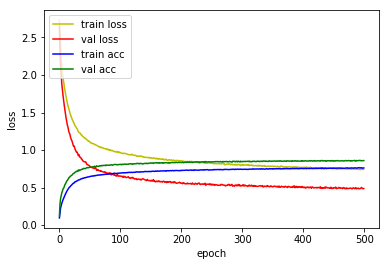

4815/4815 [==============================] - 1s 265us/sample - loss: 0.5608 - acc: 0.8289
Loss: 0.5607636648422709 Accuracy: 0.8288681

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6079 - acc: 0.1335
Epoch 00001: val_loss improved from inf to 2.28873, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_5_conv_checkpoint/001-2.2887.hdf5
36805/36805 [==============================] - 19s 521us/sample - loss: 2.6079 - acc: 0.1334 - val_loss: 2.2887 - val_acc: 0.2942
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2680 - acc: 0.2411
Epoch 00002: val_loss improved from 2.28873 to 1.99128, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_5_conv_checkpoint/002-1.9913.hdf5
36805/36805 [==============================] - 17s 463us/sample - loss: 2.2679 - acc: 0.2411 - val_loss: 1.9913 - val_acc: 0.3965
Epoch 3/500
36800/36805 [==========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8930 - acc: 0.7226
Epoch 00022: val_loss improved from 0.60103 to 0.59074, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_5_conv_checkpoint/022-0.5907.hdf5
36805/36805 [==============================] - 17s 462us/sample - loss: 0.8929 - acc: 0.7226 - val_loss: 0.5907 - val_acc: 0.8281
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8806 - acc: 0.7243
Epoch 00023: val_loss improved from 0.59074 to 0.58567, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_5_conv_checkpoint/023-0.5857.hdf5
36805/36805 [==============================] - 17s 462us/sample - loss: 0.8806 - acc: 0.7243 - val_loss: 0.5857 - val_acc: 0.8311
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8658 - acc: 0.7331
Epoch 00024: val_loss improved from 0.58567 to 0.56738, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_5_conv_ch

Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6813 - acc: 0.7911
Epoch 00046: val_loss did not improve from 0.42590
36805/36805 [==============================] - 17s 461us/sample - loss: 0.6812 - acc: 0.7911 - val_loss: 0.4332 - val_acc: 0.8730
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6721 - acc: 0.7927
Epoch 00047: val_loss improved from 0.42590 to 0.41658, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_5_conv_checkpoint/047-0.4166.hdf5
36805/36805 [==============================] - 17s 460us/sample - loss: 0.6720 - acc: 0.7927 - val_loss: 0.4166 - val_acc: 0.8793
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6685 - acc: 0.7934
Epoch 00048: val_loss improved from 0.41658 to 0.41611, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_5_conv_checkpoint/048-0.4161.hdf5
36805/36805 [==============================] - 17s 466us/sample - loss: 0.6686 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.5943 - acc: 0.8177
Epoch 00071: val_loss did not improve from 0.35737
36805/36805 [==============================] - 17s 464us/sample - loss: 0.5944 - acc: 0.8177 - val_loss: 0.3590 - val_acc: 0.8921
Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5928 - acc: 0.8181
Epoch 00072: val_loss did not improve from 0.35737
36805/36805 [==============================] - 17s 463us/sample - loss: 0.5927 - acc: 0.8181 - val_loss: 0.3646 - val_acc: 0.8880
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5886 - acc: 0.8188
Epoch 00073: val_loss did not improve from 0.35737
36805/36805 [==============================] - 17s 461us/sample - loss: 0.5886 - acc: 0.8188 - val_loss: 0.3595 - val_acc: 0.8949
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5793 - acc: 0.8220
Epoch 00074: val_loss improved from 0.35737 to 0.35370, saving model to model/chec

Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5384 - acc: 0.8327
Epoch 00097: val_loss did not improve from 0.32923
36805/36805 [==============================] - 17s 463us/sample - loss: 0.5384 - acc: 0.8326 - val_loss: 0.3326 - val_acc: 0.9029
Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5383 - acc: 0.8335
Epoch 00098: val_loss did not improve from 0.32923
36805/36805 [==============================] - 17s 461us/sample - loss: 0.5383 - acc: 0.8336 - val_loss: 0.3321 - val_acc: 0.9008
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5415 - acc: 0.8352
Epoch 00099: val_loss improved from 0.32923 to 0.32800, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_5_conv_checkpoint/099-0.3280.hdf5
36805/36805 [==============================] - 17s 463us/sample - loss: 0.5415 - acc: 0.8352 - val_loss: 0.3280 - val_acc: 0.9015
Epoch 100/500
36800/36805 [============================>.] 

Epoch 123/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4951 - acc: 0.8451
Epoch 00123: val_loss did not improve from 0.30839
36805/36805 [==============================] - 17s 465us/sample - loss: 0.4953 - acc: 0.8451 - val_loss: 0.3178 - val_acc: 0.9073
Epoch 124/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4964 - acc: 0.8457
Epoch 00124: val_loss did not improve from 0.30839
36805/36805 [==============================] - 17s 464us/sample - loss: 0.4966 - acc: 0.8456 - val_loss: 0.3207 - val_acc: 0.9059
Epoch 125/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5022 - acc: 0.8445
Epoch 00125: val_loss did not improve from 0.30839
36805/36805 [==============================] - 17s 464us/sample - loss: 0.5022 - acc: 0.8445 - val_loss: 0.3116 - val_acc: 0.9068
Epoch 126/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5067 - acc: 0.8432
Epoch 00126: val_loss did not improve from 0.30839
36805/36805 [=

Epoch 151/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4710 - acc: 0.8537
Epoch 00151: val_loss did not improve from 0.29508
36805/36805 [==============================] - 17s 463us/sample - loss: 0.4711 - acc: 0.8537 - val_loss: 0.2951 - val_acc: 0.9122
Epoch 152/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4701 - acc: 0.8548
Epoch 00152: val_loss did not improve from 0.29508
36805/36805 [==============================] - 17s 463us/sample - loss: 0.4700 - acc: 0.8548 - val_loss: 0.3062 - val_acc: 0.9094
Epoch 153/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4661 - acc: 0.8554
Epoch 00153: val_loss did not improve from 0.29508
36805/36805 [==============================] - 17s 462us/sample - loss: 0.4664 - acc: 0.8553 - val_loss: 0.3009 - val_acc: 0.9136
Epoch 154/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4729 - acc: 0.8537
Epoch 00154: val_loss did not improve from 0.29508
36805/36805 [=

Epoch 179/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4418 - acc: 0.8622
Epoch 00179: val_loss did not improve from 0.28229
36805/36805 [==============================] - 17s 462us/sample - loss: 0.4418 - acc: 0.8622 - val_loss: 0.2970 - val_acc: 0.9129
Epoch 180/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4424 - acc: 0.8625
Epoch 00180: val_loss did not improve from 0.28229
36805/36805 [==============================] - 17s 465us/sample - loss: 0.4424 - acc: 0.8625 - val_loss: 0.2904 - val_acc: 0.9180
Epoch 181/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4442 - acc: 0.8620
Epoch 00181: val_loss did not improve from 0.28229
36805/36805 [==============================] - 17s 466us/sample - loss: 0.4442 - acc: 0.8620 - val_loss: 0.3078 - val_acc: 0.9082
Epoch 182/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4473 - acc: 0.8602
Epoch 00182: val_loss did not improve from 0.28229
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.4258 - acc: 0.8662
Epoch 00207: val_loss did not improve from 0.27810
36805/36805 [==============================] - 17s 463us/sample - loss: 0.4258 - acc: 0.8662 - val_loss: 0.2863 - val_acc: 0.9189
Epoch 208/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4271 - acc: 0.8665
Epoch 00208: val_loss did not improve from 0.27810
36805/36805 [==============================] - 17s 463us/sample - loss: 0.4271 - acc: 0.8665 - val_loss: 0.2807 - val_acc: 0.9175
Epoch 209/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4246 - acc: 0.8660
Epoch 00209: val_loss did not improve from 0.27810
36805/36805 [==============================] - 17s 465us/sample - loss: 0.4246 - acc: 0.8660 - val_loss: 0.2912 - val_acc: 0.9194
Epoch 210/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4251 - acc: 0.8669
Epoch 00210: val_loss did not improve from 0.27810
36805/36805 [===============

Epoch 236/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4051 - acc: 0.8722
Epoch 00236: val_loss did not improve from 0.27436
36805/36805 [==============================] - 17s 458us/sample - loss: 0.4051 - acc: 0.8722 - val_loss: 0.2839 - val_acc: 0.9182
Epoch 237/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4127 - acc: 0.8720
Epoch 00237: val_loss did not improve from 0.27436
36805/36805 [==============================] - 17s 459us/sample - loss: 0.4127 - acc: 0.8720 - val_loss: 0.2771 - val_acc: 0.9192
Epoch 238/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4082 - acc: 0.8710
Epoch 00238: val_loss did not improve from 0.27436
36805/36805 [==============================] - 17s 458us/sample - loss: 0.4083 - acc: 0.8710 - val_loss: 0.2890 - val_acc: 0.9138
Epoch 239/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4073 - acc: 0.8709
Epoch 00239: val_loss did not improve from 0.27436
36805/36805 [=

Epoch 265/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3930 - acc: 0.8767
Epoch 00265: val_loss improved from 0.27389 to 0.27172, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_5_conv_checkpoint/265-0.2717.hdf5
36805/36805 [==============================] - 17s 466us/sample - loss: 0.3929 - acc: 0.8767 - val_loss: 0.2717 - val_acc: 0.9217
Epoch 266/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3895 - acc: 0.8760
Epoch 00266: val_loss did not improve from 0.27172
36805/36805 [==============================] - 17s 466us/sample - loss: 0.3894 - acc: 0.8760 - val_loss: 0.2765 - val_acc: 0.9196
Epoch 267/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3914 - acc: 0.8739
Epoch 00267: val_loss did not improve from 0.27172
36805/36805 [==============================] - 17s 464us/sample - loss: 0.3914 - acc: 0.8738 - val_loss: 0.2746 - val_acc: 0.9208
Epoch 268/500
36800/36805 [============================>

Epoch 294/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3768 - acc: 0.8815
Epoch 00294: val_loss did not improve from 0.27172
36805/36805 [==============================] - 17s 465us/sample - loss: 0.3767 - acc: 0.8815 - val_loss: 0.2777 - val_acc: 0.9222
Epoch 295/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3801 - acc: 0.8797
Epoch 00295: val_loss did not improve from 0.27172
36805/36805 [==============================] - 17s 466us/sample - loss: 0.3801 - acc: 0.8797 - val_loss: 0.2766 - val_acc: 0.9210
Epoch 296/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3796 - acc: 0.8790
Epoch 00296: val_loss did not improve from 0.27172
36805/36805 [==============================] - 17s 464us/sample - loss: 0.3796 - acc: 0.8790 - val_loss: 0.2775 - val_acc: 0.9231
Epoch 297/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3774 - acc: 0.8793
Epoch 00297: val_loss did not improve from 0.27172
36805/36805 [=

Epoch 323/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3620 - acc: 0.8835
Epoch 00323: val_loss did not improve from 0.26812
36805/36805 [==============================] - 17s 461us/sample - loss: 0.3620 - acc: 0.8835 - val_loss: 0.2761 - val_acc: 0.9231
Epoch 324/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3682 - acc: 0.8835
Epoch 00324: val_loss did not improve from 0.26812
36805/36805 [==============================] - 17s 461us/sample - loss: 0.3682 - acc: 0.8835 - val_loss: 0.2738 - val_acc: 0.9203
Epoch 325/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3680 - acc: 0.8827
Epoch 00325: val_loss did not improve from 0.26812
36805/36805 [==============================] - 17s 458us/sample - loss: 0.3681 - acc: 0.8827 - val_loss: 0.2756 - val_acc: 0.9224
Epoch 326/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3649 - acc: 0.8840
Epoch 00326: val_loss did not improve from 0.26812
36805/36805 [=

Epoch 353/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3544 - acc: 0.8876
Epoch 00353: val_loss did not improve from 0.26812
36805/36805 [==============================] - 17s 464us/sample - loss: 0.3543 - acc: 0.8876 - val_loss: 0.2736 - val_acc: 0.9236
Epoch 354/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3542 - acc: 0.8863
Epoch 00354: val_loss did not improve from 0.26812
36805/36805 [==============================] - 17s 464us/sample - loss: 0.3542 - acc: 0.8863 - val_loss: 0.2772 - val_acc: 0.9227
Epoch 355/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3556 - acc: 0.8864
Epoch 00355: val_loss did not improve from 0.26812
36805/36805 [==============================] - 17s 462us/sample - loss: 0.3556 - acc: 0.8863 - val_loss: 0.2805 - val_acc: 0.9224
Epoch 356/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3508 - acc: 0.8869
Epoch 00356: val_loss did not improve from 0.26812
36805/36805 [=

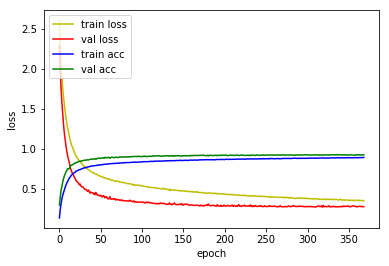

4815/4815 [==============================] - 1s 291us/sample - loss: 0.3142 - acc: 0.9055
Loss: 0.31418762652673454 Accuracy: 0.90550363

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5581 - acc: 0.1510
Epoch 00001: val_loss improved from inf to 2.12097, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv_checkpoint/001-2.1210.hdf5
36805/36805 [==============================] - 21s 562us/sample - loss: 2.5581 - acc: 0.1510 - val_loss: 2.1210 - val_acc: 0.3501
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0947 - acc: 0.3052
Epoch 00002: val_loss improved from 2.12097 to 1.70993, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv_checkpoint/002-1.7099.hdf5
36805/36805 [==============================] - 17s 475us/sample - loss: 2.0946 - acc: 0.3051 - val_loss: 1.7099 - val_acc: 0.4915
Epoch 3/500
36800/36805 [========================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5715 - acc: 0.8211
Epoch 00023: val_loss did not improve from 0.34647
36805/36805 [==============================] - 18s 479us/sample - loss: 0.5716 - acc: 0.8211 - val_loss: 0.3563 - val_acc: 0.8954
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5593 - acc: 0.8251
Epoch 00024: val_loss improved from 0.34647 to 0.33163, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv_checkpoint/024-0.3316.hdf5
36805/36805 [==============================] - 18s 483us/sample - loss: 0.5593 - acc: 0.8251 - val_loss: 0.3316 - val_acc: 0.8996
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5472 - acc: 0.8302
Epoch 00025: val_loss improved from 0.33163 to 0.30975, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv_checkpoint/025-0.3097.hdf5
36805/36805 [==============================] - 18s 479us/sample - loss: 0.5471 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.3872 - acc: 0.8789
Epoch 00047: val_loss improved from 0.22324 to 0.21823, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv_checkpoint/047-0.2182.hdf5
36805/36805 [==============================] - 18s 476us/sample - loss: 0.3872 - acc: 0.8789 - val_loss: 0.2182 - val_acc: 0.9362
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3838 - acc: 0.8799
Epoch 00048: val_loss improved from 0.21823 to 0.21485, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv_checkpoint/048-0.2148.hdf5
36805/36805 [==============================] - 18s 482us/sample - loss: 0.3838 - acc: 0.8799 - val_loss: 0.2148 - val_acc: 0.9341
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3858 - acc: 0.8819
Epoch 00049: val_loss did not improve from 0.21485
36805/36805 [==============================] - 18s 476us/sample - loss: 0.3858 - acc: 0.8819 - 

Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3107 - acc: 0.9026
Epoch 00072: val_loss improved from 0.18282 to 0.18258, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv_checkpoint/072-0.1826.hdf5
36805/36805 [==============================] - 17s 460us/sample - loss: 0.3106 - acc: 0.9026 - val_loss: 0.1826 - val_acc: 0.9439
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3101 - acc: 0.9022
Epoch 00073: val_loss improved from 0.18258 to 0.18075, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv_checkpoint/073-0.1807.hdf5
36805/36805 [==============================] - 17s 462us/sample - loss: 0.3101 - acc: 0.9022 - val_loss: 0.1807 - val_acc: 0.9469
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3120 - acc: 0.9017
Epoch 00074: val_loss improved from 0.18075 to 0.17529, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv_ch

Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2734 - acc: 0.9146
Epoch 00097: val_loss improved from 0.16149 to 0.16081, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv_checkpoint/097-0.1608.hdf5
36805/36805 [==============================] - 18s 481us/sample - loss: 0.2735 - acc: 0.9146 - val_loss: 0.1608 - val_acc: 0.9509
Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2693 - acc: 0.9158
Epoch 00098: val_loss did not improve from 0.16081
36805/36805 [==============================] - 17s 475us/sample - loss: 0.2693 - acc: 0.9158 - val_loss: 0.1610 - val_acc: 0.9497
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2725 - acc: 0.9138
Epoch 00099: val_loss did not improve from 0.16081
36805/36805 [==============================] - 17s 475us/sample - loss: 0.2725 - acc: 0.9138 - val_loss: 0.1708 - val_acc: 0.9481
Epoch 100/500
36800/36805 [============================>.] 

Epoch 125/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2379 - acc: 0.9246
Epoch 00125: val_loss did not improve from 0.15161
36805/36805 [==============================] - 18s 480us/sample - loss: 0.2379 - acc: 0.9246 - val_loss: 0.1547 - val_acc: 0.9532
Epoch 126/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2303 - acc: 0.9268
Epoch 00126: val_loss did not improve from 0.15161
36805/36805 [==============================] - 18s 478us/sample - loss: 0.2303 - acc: 0.9268 - val_loss: 0.1531 - val_acc: 0.9515
Epoch 127/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2324 - acc: 0.9256
Epoch 00127: val_loss did not improve from 0.15161
36805/36805 [==============================] - 17s 473us/sample - loss: 0.2324 - acc: 0.9256 - val_loss: 0.1550 - val_acc: 0.9511
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2350 - acc: 0.9237
Epoch 00128: val_loss did not improve from 0.15161
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.2138 - acc: 0.9320
Epoch 00153: val_loss did not improve from 0.14478
36805/36805 [==============================] - 18s 480us/sample - loss: 0.2138 - acc: 0.9320 - val_loss: 0.1551 - val_acc: 0.9513
Epoch 154/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2114 - acc: 0.9317
Epoch 00154: val_loss did not improve from 0.14478
36805/36805 [==============================] - 17s 474us/sample - loss: 0.2113 - acc: 0.9317 - val_loss: 0.1533 - val_acc: 0.9525
Epoch 155/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2114 - acc: 0.9323
Epoch 00155: val_loss did not improve from 0.14478
36805/36805 [==============================] - 17s 475us/sample - loss: 0.2114 - acc: 0.9323 - val_loss: 0.1511 - val_acc: 0.9520
Epoch 156/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2102 - acc: 0.9322
Epoch 00156: val_loss did not improve from 0.14478
36805/36805 [===============

Epoch 183/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1906 - acc: 0.9381
Epoch 00183: val_loss did not improve from 0.14478
36805/36805 [==============================] - 18s 483us/sample - loss: 0.1906 - acc: 0.9381 - val_loss: 0.1558 - val_acc: 0.9539
Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1887 - acc: 0.9395
Epoch 00184: val_loss did not improve from 0.14478
36805/36805 [==============================] - 17s 474us/sample - loss: 0.1887 - acc: 0.9395 - val_loss: 0.1553 - val_acc: 0.9525
Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1889 - acc: 0.9407
Epoch 00185: val_loss did not improve from 0.14478
36805/36805 [==============================] - 17s 472us/sample - loss: 0.1889 - acc: 0.9407 - val_loss: 0.1510 - val_acc: 0.9543
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1881 - acc: 0.9389
Epoch 00186: val_loss did not improve from 0.14478
36805/36805 [=

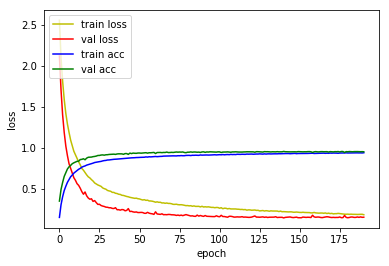

4815/4815 [==============================] - 1s 305us/sample - loss: 0.1952 - acc: 0.9383
Loss: 0.19517268415304484 Accuracy: 0.9383178

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4429 - acc: 0.1967
Epoch 00001: val_loss improved from inf to 1.83021, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_7_conv_checkpoint/001-1.8302.hdf5
36805/36805 [==============================] - 22s 606us/sample - loss: 2.4429 - acc: 0.1967 - val_loss: 1.8302 - val_acc: 0.5073
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7724 - acc: 0.4263
Epoch 00002: val_loss improved from 1.83021 to 1.27481, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_7_conv_checkpoint/002-1.2748.hdf5
36805/36805 [==============================] - 18s 502us/sample - loss: 1.7725 - acc: 0.4263 - val_loss: 1.2748 - val_acc: 0.6473
Epoch 3/500
36800/36805 [=========================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4132 - acc: 0.8702
Epoch 00023: val_loss improved from 0.25120 to 0.23601, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_7_conv_checkpoint/023-0.2360.hdf5
36805/36805 [==============================] - 19s 505us/sample - loss: 0.4132 - acc: 0.8702 - val_loss: 0.2360 - val_acc: 0.9334
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3992 - acc: 0.8745
Epoch 00024: val_loss did not improve from 0.23601
36805/36805 [==============================] - 18s 502us/sample - loss: 0.3991 - acc: 0.8746 - val_loss: 0.2372 - val_acc: 0.9308
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3923 - acc: 0.8778
Epoch 00025: val_loss improved from 0.23601 to 0.22170, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_7_conv_checkpoint/025-0.2217.hdf5
36805/36805 [==============================] - 19s 505us/sample - loss: 0.3923 - a

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2550 - acc: 0.9208
Epoch 00049: val_loss improved from 0.16141 to 0.16067, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_7_conv_checkpoint/049-0.1607.hdf5
36805/36805 [==============================] - 18s 500us/sample - loss: 0.2550 - acc: 0.9208 - val_loss: 0.1607 - val_acc: 0.9513
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2514 - acc: 0.9211
Epoch 00050: val_loss did not improve from 0.16067
36805/36805 [==============================] - 18s 500us/sample - loss: 0.2513 - acc: 0.9211 - val_loss: 0.1659 - val_acc: 0.9488
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2420 - acc: 0.9240
Epoch 00051: val_loss improved from 0.16067 to 0.15564, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_7_conv_checkpoint/051-0.1556.hdf5
36805/36805 [==============================] - 19s 504us/sample - loss: 0.2420 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.1878 - acc: 0.9414
Epoch 00075: val_loss improved from 0.13825 to 0.13394, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_7_conv_checkpoint/075-0.1339.hdf5
36805/36805 [==============================] - 18s 493us/sample - loss: 0.1878 - acc: 0.9414 - val_loss: 0.1339 - val_acc: 0.9592
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1827 - acc: 0.9410
Epoch 00076: val_loss did not improve from 0.13394
36805/36805 [==============================] - 18s 495us/sample - loss: 0.1827 - acc: 0.9410 - val_loss: 0.1399 - val_acc: 0.9555
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1838 - acc: 0.9412
Epoch 00077: val_loss did not improve from 0.13394
36805/36805 [==============================] - 18s 493us/sample - loss: 0.1838 - acc: 0.9412 - val_loss: 0.1359 - val_acc: 0.9576
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1479 - acc: 0.9534
Epoch 00103: val_loss did not improve from 0.12347
36805/36805 [==============================] - 18s 490us/sample - loss: 0.1479 - acc: 0.9534 - val_loss: 0.1339 - val_acc: 0.9567
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1448 - acc: 0.9528
Epoch 00104: val_loss did not improve from 0.12347
36805/36805 [==============================] - 18s 496us/sample - loss: 0.1448 - acc: 0.9528 - val_loss: 0.1315 - val_acc: 0.9595
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1450 - acc: 0.9525
Epoch 00105: val_loss did not improve from 0.12347
36805/36805 [==============================] - 18s 494us/sample - loss: 0.1451 - acc: 0.9525 - val_loss: 0.1350 - val_acc: 0.9581
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1489 - acc: 0.9517
Epoch 00106: val_loss did not improve from 0.12347
36805/36805 [=

Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9603
Epoch 00132: val_loss did not improve from 0.12102
36805/36805 [==============================] - 18s 490us/sample - loss: 0.1229 - acc: 0.9603 - val_loss: 0.1304 - val_acc: 0.9618
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1171 - acc: 0.9613
Epoch 00133: val_loss did not improve from 0.12102
36805/36805 [==============================] - 18s 492us/sample - loss: 0.1171 - acc: 0.9613 - val_loss: 0.1314 - val_acc: 0.9623
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1200 - acc: 0.9601
Epoch 00134: val_loss did not improve from 0.12102
36805/36805 [==============================] - 18s 493us/sample - loss: 0.1200 - acc: 0.9600 - val_loss: 0.1394 - val_acc: 0.9578
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1197 - acc: 0.9605
Epoch 00135: val_loss did not improve from 0.12102
36805/36805 [=

Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1012 - acc: 0.9657
Epoch 00162: val_loss did not improve from 0.12102
36805/36805 [==============================] - 18s 492us/sample - loss: 0.1012 - acc: 0.9657 - val_loss: 0.1341 - val_acc: 0.9616
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0983 - acc: 0.9679
Epoch 00163: val_loss did not improve from 0.12102
36805/36805 [==============================] - 18s 494us/sample - loss: 0.0984 - acc: 0.9679 - val_loss: 0.1427 - val_acc: 0.9562
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1042 - acc: 0.9662
Epoch 00164: val_loss did not improve from 0.12102
36805/36805 [==============================] - 18s 494us/sample - loss: 0.1042 - acc: 0.9662 - val_loss: 0.1383 - val_acc: 0.9623
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0971 - acc: 0.9668
Epoch 00165: val_loss did not improve from 0.12102
36805/36805 [=

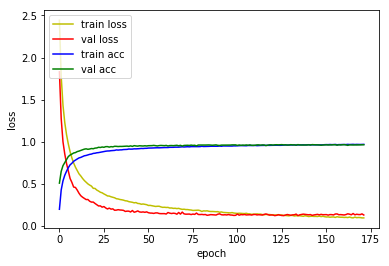

4815/4815 [==============================] - 2s 317us/sample - loss: 0.1875 - acc: 0.9456
Loss: 0.18745066056710785 Accuracy: 0.9455867

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4047 - acc: 0.2185
Epoch 00001: val_loss improved from inf to 1.63711, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_8_conv_checkpoint/001-1.6371.hdf5
36805/36805 [==============================] - 23s 623us/sample - loss: 2.4046 - acc: 0.2185 - val_loss: 1.6371 - val_acc: 0.5132
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6074 - acc: 0.4836
Epoch 00002: val_loss improved from 1.63711 to 1.16170, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_8_conv_checkpoint/002-1.1617.hdf5
36805/36805 [==============================] - 18s 493us/sample - loss: 1.6073 - acc: 0.4836 - val_loss: 1.1617 - val_acc: 0.6420
Epoch 3/500
36800/36805 [=========================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3386 - acc: 0.8929
Epoch 00023: val_loss did not improve from 0.24976
36805/36805 [==============================] - 18s 495us/sample - loss: 0.3386 - acc: 0.8929 - val_loss: 0.2625 - val_acc: 0.9164
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3261 - acc: 0.8968
Epoch 00024: val_loss improved from 0.24976 to 0.24598, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_8_conv_checkpoint/024-0.2460.hdf5
36805/36805 [==============================] - 18s 497us/sample - loss: 0.3261 - acc: 0.8968 - val_loss: 0.2460 - val_acc: 0.9206
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3233 - acc: 0.8977
Epoch 00025: val_loss improved from 0.24598 to 0.24062, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_8_conv_checkpoint/025-0.2406.hdf5
36805/36805 [==============================] - 18s 496us/sample - loss: 0.3233 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.1925 - acc: 0.9368
Epoch 00047: val_loss did not improve from 0.16744
36805/36805 [==============================] - 18s 496us/sample - loss: 0.1925 - acc: 0.9369 - val_loss: 0.1716 - val_acc: 0.9464
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1845 - acc: 0.9396
Epoch 00048: val_loss did not improve from 0.16744
36805/36805 [==============================] - 18s 495us/sample - loss: 0.1845 - acc: 0.9396 - val_loss: 0.1695 - val_acc: 0.9464
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1827 - acc: 0.9405
Epoch 00049: val_loss improved from 0.16744 to 0.16458, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_DO_8_conv_checkpoint/049-0.1646.hdf5
36805/36805 [==============================] - 18s 494us/sample - loss: 0.1827 - acc: 0.9406 - val_loss: 0.1646 - val_acc: 0.9471
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1204 - acc: 0.9601
Epoch 00075: val_loss did not improve from 0.14974
36805/36805 [==============================] - 18s 498us/sample - loss: 0.1204 - acc: 0.9601 - val_loss: 0.1507 - val_acc: 0.9525
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1168 - acc: 0.9613
Epoch 00076: val_loss did not improve from 0.14974
36805/36805 [==============================] - 18s 493us/sample - loss: 0.1168 - acc: 0.9613 - val_loss: 0.1586 - val_acc: 0.9513
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1119 - acc: 0.9624
Epoch 00077: val_loss did not improve from 0.14974
36805/36805 [==============================] - 18s 494us/sample - loss: 0.1119 - acc: 0.9624 - val_loss: 0.1546 - val_acc: 0.9548
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1134 - acc: 0.9621
Epoch 00078: val_loss did not improve from 0.14974
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0794 - acc: 0.9728
Epoch 00104: val_loss did not improve from 0.14904
36805/36805 [==============================] - 18s 496us/sample - loss: 0.0794 - acc: 0.9728 - val_loss: 0.1752 - val_acc: 0.9564
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0823 - acc: 0.9720
Epoch 00105: val_loss did not improve from 0.14904
36805/36805 [==============================] - 19s 504us/sample - loss: 0.0823 - acc: 0.9720 - val_loss: 0.1831 - val_acc: 0.9532
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0833 - acc: 0.9717
Epoch 00106: val_loss did not improve from 0.14904
36805/36805 [==============================] - 18s 499us/sample - loss: 0.0833 - acc: 0.9717 - val_loss: 0.1661 - val_acc: 0.9567
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0750 - acc: 0.9739
Epoch 00107: val_loss did not improve from 0.14904
36805/36805 [===============

Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0565 - acc: 0.9808
Epoch 00134: val_loss did not improve from 0.14904
36805/36805 [==============================] - 19s 504us/sample - loss: 0.0565 - acc: 0.9808 - val_loss: 0.1926 - val_acc: 0.9592
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9809
Epoch 00135: val_loss did not improve from 0.14904
36805/36805 [==============================] - 18s 501us/sample - loss: 0.0559 - acc: 0.9809 - val_loss: 0.1946 - val_acc: 0.9564
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0590 - acc: 0.9795
Epoch 00136: val_loss did not improve from 0.14904
36805/36805 [==============================] - 18s 500us/sample - loss: 0.0590 - acc: 0.9795 - val_loss: 0.1924 - val_acc: 0.9585
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0549 - acc: 0.9814
Epoch 00137: val_loss did not improve from 0.14904
36805/36805 [=

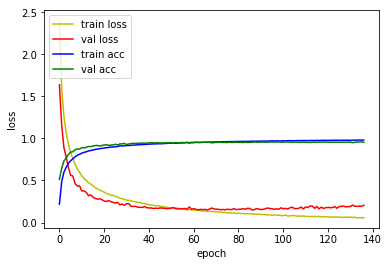

4815/4815 [==============================] - 2s 322us/sample - loss: 0.2199 - acc: 0.9383
Loss: 0.21994790246058352 Accuracy: 0.9383178



In [10]:
base = '1D_CNN_custom_multi_2_GMP_ch_32_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GMP_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
____________________________________________________________

4815/4815 [==============================] - 2s 322us/sample - loss: 0.3142 - acc: 0.9055
Loss: 0.31418762652673454 Accuracy: 0.90550363

1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 32)    192         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 32)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxP

4815/4815 [==============================] - 2s 339us/sample - loss: 0.1875 - acc: 0.9456
Loss: 0.18745066056710785 Accuracy: 0.9455867

1D_CNN_custom_multi_2_GMP_ch_32_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 32)    192         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 32)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxPo

In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GMP_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
____________________________________________________________

4815/4815 [==============================] - 2s 368us/sample - loss: 0.3168 - acc: 0.9063
Loss: 0.3167691239439191 Accuracy: 0.9063344

1D_CNN_custom_multi_2_GMP_ch_32_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 32)    192         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 32)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPoo

4815/4815 [==============================] - 2s 374us/sample - loss: 0.2123 - acc: 0.9454
Loss: 0.21231936488536535 Accuracy: 0.945379

1D_CNN_custom_multi_2_GMP_ch_32_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 32)    192         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 32)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxPoo